In [87]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers import linear
import time

In [88]:
# define the two sets of points
rngs = jax.random.split(jax.random.key(0), 42)
size = 100
mu_1 = jax.random.normal(rngs[0], (size, 1))
mu_2 = jax.random.normal(rngs[1], (size, 1)) # sizes can be different
print(mu_1.shape, mu_2.shape)

(100, 1) (100, 1)


In [89]:
geom = pointcloud.PointCloud(mu_1, mu_2, cost_fn=None)
solve_fn = jax.jit(linear.solve)
ot = solve_fn(geom)
print(ot.matrix)

[[1.1375844e-03 4.3346362e-13 6.5655093e-19 ... 3.8484090e-38
  1.8396145e-19 6.1329547e-06]
 [3.1226477e-19 1.8411959e-04 3.8531469e-04 ... 7.5931833e-10
  3.5981959e-04 5.3882726e-08]
 [5.7925801e-05 9.5072520e-25 3.3656640e-33 ... 0.0000000e+00
  5.6297841e-34 5.0963660e-13]
 ...
 [3.1670618e-17 3.0547570e-04 2.2504054e-04 ... 4.4464141e-11
  1.9227529e-04 5.4992410e-07]
 [1.0571874e-20 1.0540439e-04 4.5219762e-04 ... 4.3320743e-09
  4.4889131e-04 8.8461167e-09]
 [4.0637987e-31 1.8609290e-07 7.0336173e-05 ... 1.2975184e-05
  1.0223346e-04 6.4466687e-15]]


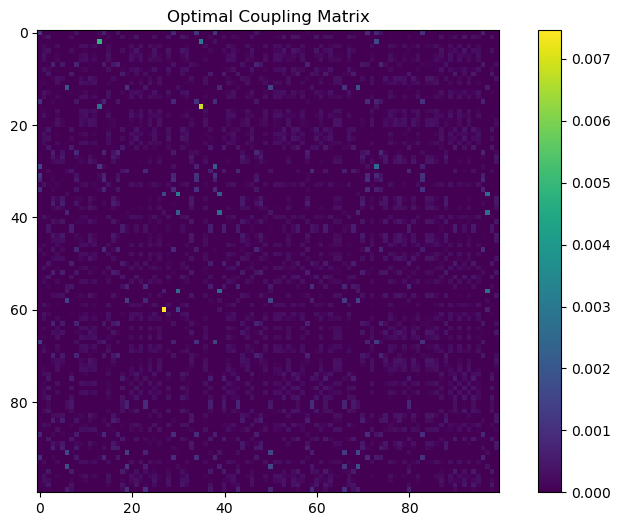

In [90]:
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

In [91]:
solve_fn = jax.jit(linear.solve)

def random_ott_experiment(n, eps):
    t1 = time.time()
    """runs an OT experiment between two collections of n random 2-D points, with random probabilities"""
    rngs = jax.random.split(jax.random.key(4), 42)
    x_1 = jax.random.normal(rngs[0], (n, 2))
    x_2 = jax.random.normal(rngs[1], (n, 2))
    mu_1 = jax.random.normal(rngs[2], (n,))
    mu_2 = jax.random.normal(rngs[3], (n,))
    mu_1 = jnp.exp(mu_1) / jnp.sum(jnp.exp(mu_1)) # normalize probability distributions with softmax
    mu_2 = jnp.exp(mu_2) / jnp.sum(jnp.exp(mu_2))
    geom = pointcloud.PointCloud(x_1, x_2, epsilon=eps)
    print(f'epsilon={geom.epsilon}')
    ot = solve_fn(geom, a=mu_1, b=mu_2)
    return ot, ot.dual_cost, ot.primal_cost, ot.reg_ot_cost, time.time() - t1

print(mu_1.shape, mu_2.shape)
sizes = [2**k for k in range(10)]
results = []
for size in sizes:
    print(size)
    results.append(list(random_ott_experiment(size, None)))

(100, 1) (100, 1)
1
epsilon=0.0
2
epsilon=0.09889372438192368
4
epsilon=0.11305730789899826
8
epsilon=0.18965944647789001
16
epsilon=0.16332343220710754
32
epsilon=0.1968887746334076
64
epsilon=0.19226522743701935
128
epsilon=0.19959069788455963
256
epsilon=0.1962318867444992
512
epsilon=0.1885523796081543


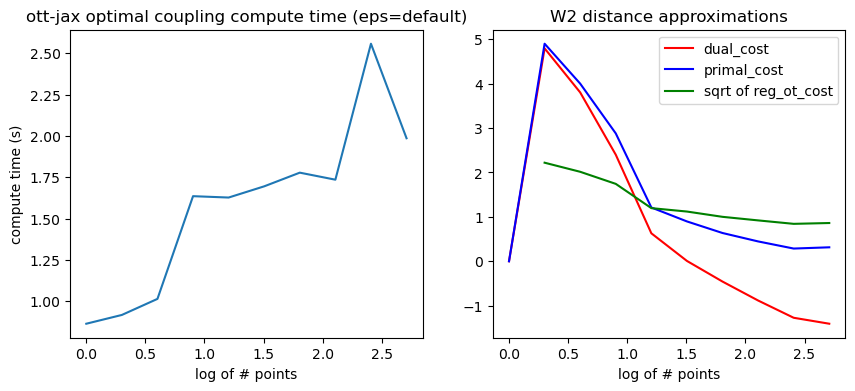

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
logsizes = [jnp.log10(x) for x in sizes]
ax1.plot(logsizes, [float(row[4]) for row in results])
ax1.set_ylabel('compute time (s)')
ax1.set_xlabel('log of # points')
ax1.set_title('ott-jax optimal coupling compute time (eps=default)')
ax2.plot(logsizes, [float(row[1]) for row in results], color='r', label='dual_cost')
ax2.plot(logsizes, [float(row[2]) for row in results], color='b', label='primal_cost')
ax2.plot(logsizes, [jnp.sqrt(float(row[3])) for row in results], color='g', label='sqrt of reg_ot_cost')

ax2.set_xlabel('log of # points')
ax2.set_title('W2 distance approximations')
ax2.legend()

plt.show()

In [93]:
size = 8000
epsilons = [10**(-x) for x in range(8)]
results = []
for eps in epsilons:
    print(size)
    results.append(list(random_ott_experiment(size, eps)))

8000
epsilon=1.0
8000
epsilon=0.1
8000
epsilon=0.01
8000
epsilon=0.001
8000
epsilon=0.0001
8000
epsilon=1e-05
8000
epsilon=1e-06
8000
epsilon=1e-07


[1.8149595260620117, 0.4061794579029083, 0.07258599996566772, 0.02047830820083618, 0.012173395603895187, 0.007917836308479309, 0.004984717816114426, 0.003768499009311199]


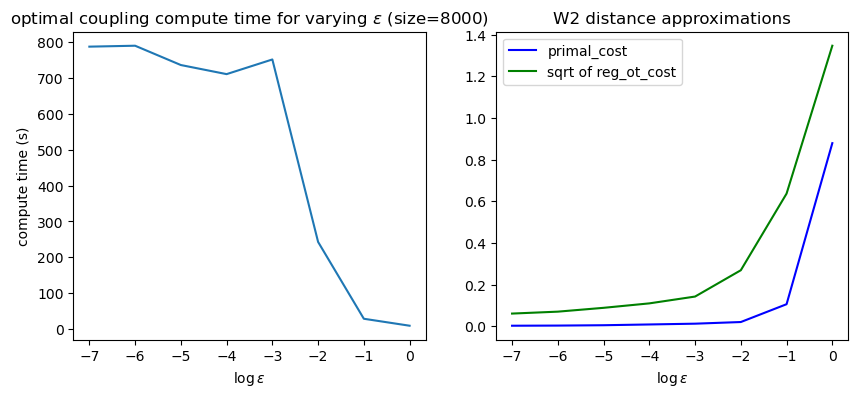

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
logepsilons = jnp.log10(jnp.array(epsilons))
ax1.plot(logepsilons, [float(row[4]) for row in results])
ax1.set_ylabel('compute time (s)')
ax1.set_xlabel('$\log \epsilon$')
ax1.set_title(f'optimal coupling compute time for varying $\epsilon$ (size={size})')
#ax2.plot(logepsilons, [float(row[1]) for row in results], color='r', label='dual_cost')
print([float(row[3]) for row in results])
ax2.plot(logepsilons, [float(row[2]) for row in results], color='b', label='primal_cost')
ax2.plot(logepsilons, [jnp.sqrt(float(row[3])) for row in results], color='g', label='sqrt of reg_ot_cost')
ax2.set_xlabel('$\log \epsilon$')
ax2.set_title('W2 distance approximations')
ax2.legend()

plt.show()

## Multiple options for computing $W_2$ distance

- SinkhornOutput.reg_ot_cost 
    - (Array | None) – the regularized optimal transport cost. By default this is the linear contribution + KL term
    - Apply `sqrt` to get the $W_2$ distance
- SinkhornOutput.primal_cost 
    - Return transport cost of current transport solution at geometry.
    - Should be the exact expected transport distance of the optimal coupling?

In [95]:
ot, _, _, _, _ = random_ott_experiment(20, 1e-3)
print(f'SinkhornOutput.primal_cost {ot.primal_cost}')
ex_dis = jnp.dot(ot.geom.cost_matrix.ravel(), ot.matrix.ravel())
print(f'expected distance w.r.t coupling: {ex_dis}')
print(f'SinkhornOutput.reg_ot_cost {ot.reg_ot_cost}')

epsilon=0.001
SinkhornOutput.primal_cost 0.9247430562973022
expected distance w.r.t coupling: 0.9247605204582214
SinkhornOutput.reg_ot_cost 1.3827486038208008


epsilon=1.0
epsilon=0.10000000149011612
epsilon=0.009999999776482582
epsilon=0.0010000000474974513
epsilon=9.999999747378752e-05
epsilon=9.999999747378752e-06
epsilon=9.999999974752427e-07
epsilon=1.0000000116860974e-07
epsilon=9.99999993922529e-09
epsilon=9.999999717180685e-10
[1.955448   1.6044232  1.5985463  0.9247605  0.4878074  0.43069664
 0.41071522 0.41635618 3.7951891  7.7932525 ]


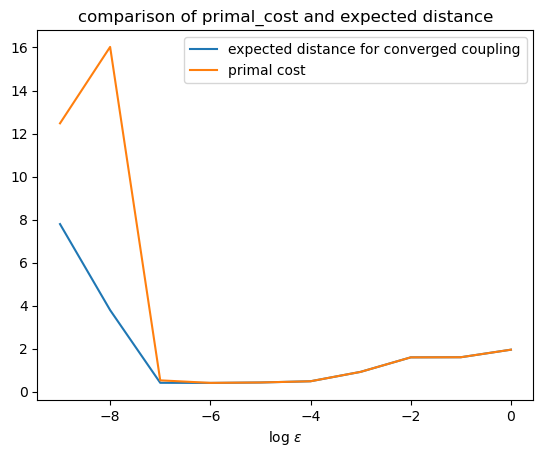

In [96]:
results = []
epsilons = jnp.array([10**(-x) for x in range(10)])
for eps in epsilons:
    ot, _, _, _, _ = random_ott_experiment(20, eps)
    ex_dis = jnp.dot(ot.geom.cost_matrix.ravel(), ot.matrix.ravel())
    results.append([ex_dis, ot.primal_cost])
results = jnp.array(results)
print(results[:, 0])
plt.plot(jnp.log10(epsilons), results[:, 0], label='expected distance for converged coupling')
plt.plot(jnp.log10(epsilons), results[:, 1], label='primal cost')
plt.xlabel('log $\epsilon$')
plt.legend()
plt.title('comparison of primal_cost and expected distance')
plt.show()